In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import json # for saving data

# Set up environment

In [17]:
# Set seeds for reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(20221123)
torch.manual_seed(20221123)
random.seed(20221123)

# Use GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

################################# Data Directory #######################################
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = os.path.join('/content','drive','MyDrive','BsC_Project_Data','T8Colored')
except:
    data_dir = os.path.join('TFR_plots','T8Colored')
########################################################################################

DRIVE_RES_DIR = os.path.join('/content','drive','MyDrive','BsC_Project_Data','Results')
EPOCHS = 25
BATCH_SIZE = 8

In [32]:
# Image transform, perhaps include data augmentation, NOTE: transform is currently applied to all data, so NO augment
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet specific normalization
        ])

# Test Subjects
Subjects = ["Subject"+str(i) for i in range(10,16)]

image_datasets = {subject: datasets.ImageFolder(os.path.join(data_dir, subject), #Transform applied to all data!!
                                          transform) for subject in Subjects}

# Data splitting, different for intra- and inter-subject model.
########################## Intra subject, Subject 10 ######################
#dataset = image_datasets["Subject10"]
#train_set, val_set = torch.utils.data.random_split(dataset,[292,60])
########################## Inter subject, Subj10 test #####################
TestSubj = Subjects[0]
del Subjects[0]
train_set = torch.utils.data.ConcatDataset([image_datasets[subject] for subject in Subjects])
val_set = image_datasets[TestSubj]
###########################################################################
image_datasets = {"train":train_set, "val":val_set}

# Prepare data loader
dataloaders = {phase: torch.utils.data.DataLoader(image_datasets[phase], batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=4) for phase in ["train", "val"]}

dataset_sizes = {phase: len(image_datasets[phase]) for phase in ["train", "val"]}

#class_names = image_datasets["train"].classes
class_names = val_set.classes

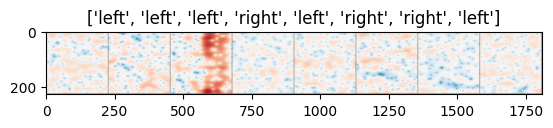

In [31]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # Store results
    lossvec = {"train":[], "val":[]} 
    accvec = {"train":[], "val":[]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            lossvec[phase].append(epoch_loss)
            accvec[phase].append(epoch_acc.item())
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, lossvec, accvec

In [ ]:
def GenPlot(epochs,loss,acc,name):
    X = range(epochs)
    fig,ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(X,loss["train"],label="train", color="blue")
    ax[0].plot(X,loss["val"],label="val", color="red")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[1].plot(X,acc["train"],label="train", color="blue")
    ax[1].plot(X,acc["val"],label="val", color="red")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    fig.suptitle(name,fontsize=16)
    plt.subplots_adjust(wspace=0.2)

In [ ]:
def saveResults(loss,acc,name,path,model = None):
    partialname = os.path.join(path,name)
    resDict = {name:{"loss":loss,"acc":acc}}
    with open(partialname+".json", 'w', encoding='utf-8') as f:
        json.dump(resDict, f, ensure_ascii=False, indent=4)
    if model:
        torch.save(model.state_dict(), partialname+".pth")

# Tune full model

In [ ]:
model_ft = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft, loss_ft, acc_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=EPOCHS, dataloaders=dataloaders, dataset_sizes=dataset_sizes)

Epoch 0/24
----------


KeyboardInterrupt: 

In [ ]:
name = "Full Tune"
saveResults(loss_ft,acc_ft,name,DRIVE_RES_DIR)

In [ ]:
GenPlot(EPOCHS,loss_ft,acc_ft,"Pre-Trained ResNet18 Tune")

# Train last layer, freeze rest

In [6]:
model_conv = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
# Set last deep layer as trainable
model_conv.layer4[1].conv1 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_conv.layer4[1].bn1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
model_conv.layer4[1].conv2 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_conv.layer4[1].bn2 = nn.Dropout(p=0.5,inplace=True)

# Create classifier layer with dropout for overfit prevention
model_conv.fc = nn.Sequential(
    nn.Dropout(p=0.5,inplace=True),
    nn.Linear(num_ftrs, 2) 
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
#model_conv, loss_conv, acc_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
#                       num_epochs=EPOCHS)

Epoch 0/24
----------


KeyboardInterrupt: 

In [ ]:
#name = "PT_ResNet_Freeze"
#saveResults(loss_conv,acc_conv,name,DRIVE_RES_DIR)

In [ ]:
#GenPlot(EPOCHS,loss_conv,acc_conv,"Pre-Trained ResNet18 Frozen")